# Examine ALOS2 Archive for Name_SAG1NS_220aa.shp
### full catalog search (*no ability to download as of 10/2018)
https://satpf.jp/spf/?sb=search&sensor=ALOS-2_PALSAR-2&item=sb1_sar_palser2

### JAXA search requires old version of firefox that can use Microsoft silverlight (can download csv, kmz, shp)
https://auig2.jaxa.jp/ips/home?language=en_US


In [1]:
import pandas as pd
from pandas.plotting import table
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
%matplotlib inline
#%qtconsole
plt.rcParams['font.size'] = 12

In [3]:
# Read everything 
# !! WARNING !! need to add comma at end of first row of heading labels
vectorFile = '/Users/scott/Documents/GitHub/snowex/snowex2019/ca-id-ut/Name_SAG1NS_220aa.shp'
path = '/Users/scott/Documents/GitHub/snowex/snowex2019/ca-id-ut/Name_SAG1NS_220aa-ALOS2.csv'
df = pd.read_csv(path)

In [4]:
# Convenient Summary!
df.groupby(["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number", "Beam No"])["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number  Beam No
Ascending        SM2             66               780                  FP6-3       2
                                                  790                  FP6-3       2
                                 67               770                  FP6-6       2
                                                                       FP6-7       1
                                                                       H2-7        1
                                                                       H2-8        1
                                                  780                  FP6-6       2
                                                                       FP6-7       1
                                                                       H2-7        1
                                                                       H2-8        1
                 SM3             67               770                  

In [5]:
# # NOTE that only same Operation Mode, OBS Path, Frame, Beam No, can be used for interferometry
# Select count > 2 from this groupby
order = ["Orbit Direction", "Operation Mode", "OBS Path Number", "Centre Frame Number", "Beam No"]
DF = df.groupby(order).filter(lambda x: len(x["Scene ID"]) >= 2)
# Reprint summary as groupby object
DF.groupby(order)["Scene ID"].count()

Orbit Direction  Operation Mode  OBS Path Number  Centre Frame Number  Beam No
Ascending        SM2             66               780                  FP6-3       2
                                                  790                  FP6-3       2
                                 67               770                  FP6-6       2
                                                  780                  FP6-6       2
                 SM3             67               770                  F2-6        7
                                                  780                  F2-6        7
                                                                       F2-7        7
                 WD1             66               750                  W2          5
                                                  800                  W2          2
                                 67               750                  W2          6
                                                  800                  

In [6]:
# NOTE: an alternative to the above!

# Select only paths with more than 10 coincidident acquisitions
#idx = df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].count().gt(10) #RETURNS GROUP-BY
#idx = df.groupby(["Operation Mode", "OBS Path Number"])["Scene ID"].transform("count").gt(10) # RETURNS dataframe index
#DF = df[idx]

In [7]:
def make_footprints(df):
    """ extract shapely polygon footprint"""
    polys = []
    for i,row in df.iterrows():
        uly = row["Scene Upper Left Latitude"]
        ulx = row["Scene Upper Left Longitude"]
        ury = row["Scene Upper Right Latitude"] 
        urx = row["Scene Upper Right Longitude"]
        lly = row["Scene Lower Left Latitude"] 
        llx = row["Scene Lower Left Longitude"] 
        lry = row["Scene Lower Right Latitude"]
        lrx = row["Scene Lower Right Longitude"]
        coords = [ (ulx, uly), (urx, ury), (lrx, lry), (llx, lly), (ulx, uly)]
        polys.append(shapely.geometry.Polygon(np.array(coords).astype('f4')))

    return polys

In [8]:
# Add Polygon footprints
polys = make_footprints(DF)
gf = gpd.GeoDataFrame(DF, geometry=polys, crs={'init': 'epsg:4326'})

# Keep most relevant columns
cols = ["Scene ID", 
        "Operation Mode", 
        "Beam No",
        "OBS Path Number", 
        "Centre Frame Number", 
        "Observation Start Date", 
        "Orbit Direction",
        "Off Nadir Angle",
        "Polarization", 
        "geometry"] 
gf = gf.loc[:, cols]
gf.head()

Scene ID Operation Mode Beam No  OBS Path Number  \
0  ALOS2011342800-140808            WD1      W2              168   
1  ALOS2011342850-140808            WD1      W2              168   
2  ALOS2012082800-140813            WD1      W2              169   
3  ALOS2012082850-140813            WD1      W2              169   
4  ALOS2013190750-140821            WD1      W2               67   

   Centre Frame Number Observation Start Date Orbit Direction  \
0                 2800    2014/08/08 13:03:29      Descending   
1                 2850    2014/08/08 13:03:29      Descending   
2                 2800    2014/08/13 13:09:06      Descending   
3                 2850    2014/08/13 13:09:06      Descending   
4                  750    2014/08/21 00:53:12       Ascending   

   Off Nadir Angle Polarization  \
0             34.9        HH+HV   
1             34.9        HH+HV   
2             34.9        HH+HV   
3             34.9        HH+HV   
4             34.9        HH+HV   

                                            geometry  
0  POLYGON ((-121.7740020751953 42.38899993896484...  
1  POLYGON ((-122.2539978027344 39.91999816894531...  
2  POLYGON ((-123.5149993896484 42.38899993896484...  
3  POLYGON ((-123.995002746582 39.91999816894531,...  
4  POLYGON ((-122.1969985961914 39.37300109863281...

In [9]:
# Rename to dinosar conventions
gf.rename(columns={"Observation Start Date" : 'sceneDate', 
                "OBS Path Number" : 'relativeOrbit', 
                "Orbit Direction" : 'flightDirection',
                "Scene ID" : 'sceneId',
                "Operation Mode" : 'opMode',
                "Beam No" : 'beamNo',
                "Centre Frame Number" : 'frame',
                "Off Nadir Angle" : 'incidence',
                "Polarization" : 'polarization'}, 
         inplace=True)
#gf.to_file('query-alos2-dinosar.geojson', driver='GeoJSON')

In [10]:
# Plot these frames on a map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import GoogleTiles

In [11]:
def plot_map(gf, snwe, vectorFile=None, zoom=8, title='Orbital Footprints', tableFrame=None):
    pad = 1
    S, N, W, E = snwe
    plot_CRS = ccrs.PlateCarree()
    geodetic_CRS = ccrs.Geodetic()
    x0, y0 = plot_CRS.transform_point(W-pad, S-pad, geodetic_CRS)
    x1, y1 = plot_CRS.transform_point(E+pad, N+pad, geodetic_CRS)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150,
                           subplot_kw=dict(projection=plot_CRS))

    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    url = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
    tiler = GoogleTiles(url=url)
    # NOTE: going higher than zoom=8 is slow...
    ax.add_image(tiler, zoom)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='110m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='k', linestyle=':')
    ax.coastlines(resolution='10m', color='black', linewidth=2)
    ax.add_feature(cfeature.BORDERS)
    
    if type(tableFrame) == gpd.geodataframe.GeoDataFrame:
        table(ax, tableFrame, loc='top', zorder=10, fontsize=10,
          cellLoc='center', rowLoc='center',
          bbox=[0.1, 0.7, 0.6, 0.3]) 

    # Add region of interest polygon in specified
    if vectorFile:
        tmp = gpd.read_file(vectorFile)
        ax.add_geometries(tmp.geometry.values,
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor='m',
                          lw=2,
                          linestyle='dashed')

    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    for orbit, color in zip(orbits, colors):
        df = gf.query('relativeOrbit == @orbit')
        poly = df.geometry.cascaded_union

        if df.flightDirection.iloc[0] == 'ASCENDING':
            linestyle = '--'
            xpos, ypos = poly.centroid.x, poly.bounds[3]
        else:
            linestyle = '-'
            xpos, ypos = poly.centroid.x, poly.bounds[1]

        ax.add_geometries([poly],
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor=color,
                          lw=2,
                          linestyle=linestyle)
        ax.text(xpos, ypos, orbit, color=color, fontsize=16, fontweight='bold',
                transform=geodetic_CRS)

    gl = ax.gridlines(plot_CRS, draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.title(title)
    plt.savefig('map.pdf', bbox_inches='tight')

In [12]:
def plot_timeline(gf, title='Acquisition Timeline'):
    """Plot dinosar inventory acquisitions as a timeline.

    Parameters
    ----------
    gf :  GeoDataFrame
        A geopandas GeoDataFrame

    """

    # Same colors as map
    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    fig, ax = plt.subplots(figsize=(11, 8.5))
    plt.scatter(gf.timeStamp.values, gf.orbitCode.values,
                edgecolors=colors[gf.orbitCode.values], facecolors='None',
                cmap='jet', s=60, label='ALOS-2')

    plt.yticks(gf.orbitCode.unique(), gf.relativeOrbit.unique())

    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.legend(loc='lower right')
    plt.ylim(-1, orbits.size)
    plt.ylabel('Orbit Number')
    fig.autofmt_xdate()
    plt.title(title)
    plt.savefig('timeline.pdf', bbox_inches='tight')

In [13]:
def print_dates(GF):
    ''' print list of dates from dataframe'''
    tmp = GF.loc[:, ['sceneId','sceneDate']].reset_index(drop=True)
    tmp.loc[:, 'timeStamp'] = pd.to_datetime(tmp.sceneDate)
    tmp['date'] = tmp.sceneDate.str[:10]
    timeDeltas = tmp.timeStamp.diff()
    tmp['dt'] = timeDeltas.dt.days
    tmp.loc[0, 'dt'] = 0
    tmp['dt'] = tmp.dt.astype('i2')
    return tmp.loc[:, ['date','dt']]

In [14]:
gf.head()

sceneId opMode beamNo  relativeOrbit  frame  \
0  ALOS2011342800-140808    WD1     W2            168   2800   
1  ALOS2011342850-140808    WD1     W2            168   2850   
2  ALOS2012082800-140813    WD1     W2            169   2800   
3  ALOS2012082850-140813    WD1     W2            169   2850   
4  ALOS2013190750-140821    WD1     W2             67    750   

             sceneDate flightDirection  incidence polarization  \
0  2014/08/08 13:03:29      Descending       34.9        HH+HV   
1  2014/08/08 13:03:29      Descending       34.9        HH+HV   
2  2014/08/13 13:09:06      Descending       34.9        HH+HV   
3  2014/08/13 13:09:06      Descending       34.9        HH+HV   
4  2014/08/21 00:53:12       Ascending       34.9        HH+HV   

                                            geometry  
0  POLYGON ((-121.7740020751953 42.38899993896484...  
1  POLYGON ((-122.2539978027344 39.91999816894531...  
2  POLYGON ((-123.5149993896484 42.38899993896484...  
3  POLYGON ((-123.995002746582 39.91999816894531,...  
4  POLYGON ((-122.1969985961914 39.37300109863281...

In [15]:
# Generate plots for all possible interferometric pairs (with dinosar naming scheme)
order = ["flightDirection", "opMode", "relativeOrbit", "frame", "beamNo"]
GF = gf.groupby(order).filter(lambda x: len(x["sceneId"]) > 2)
# Reprint summary as groupby object

w, s, e, n = GF.geometry.cascaded_union.bounds
snwe = [s, n, w, e]

GF.groupby(order)["sceneId"].count()

flightDirection  opMode  relativeOrbit  frame  beamNo
Ascending        SM3     67             770    F2-6       7
                                        780    F2-6       7
                                               F2-7       7
                 WD1     66             750    W2         5
                         67             750    W2         6
                                        800    W2         6
                         68             750    W2         5
                                        800    W2         5
Descending       SM3     168            2820   F2-6      14
                                               F2-7      11
                                        2830   F2-7      11
                         169            2820   F2-5       5
                 WD1     167            2800   W2        29
                                        2850   W2        46
                         168            2800   W2        31
                                        2850  

In [16]:
GB = GF.groupby(order)["sceneId"]
print(GB.groups)

{('Ascending', 'SM3', 67, 770, 'F2-6'): Int64Index([14, 37, 82, 147, 218, 231, 270], dtype='int64'), ('Ascending', 'SM3', 67, 780, 'F2-6'): Int64Index([15, 38, 83, 148, 219, 232, 271], dtype='int64'), ('Ascending', 'SM3', 67, 780, 'F2-7'): Int64Index([9, 36, 122, 150, 165, 230, 273], dtype='int64'), ('Ascending', 'WD1', 66, 750, 'W2'): Int64Index([8, 74, 79, 138, 204], dtype='int64'), ('Ascending', 'WD1', 67, 750, 'W2'): Int64Index([4, 26, 75, 136, 200, 294], dtype='int64'), ('Ascending', 'WD1', 67, 800, 'W2'): Int64Index([5, 27, 76, 137, 201, 295], dtype='int64'), ('Ascending', 'WD1', 68, 750, 'W2'): Int64Index([6, 30, 77, 202, 298], dtype='int64'), ('Ascending', 'WD1', 68, 800, 'W2'): Int64Index([7, 31, 78, 203, 299], dtype='int64'), ('Descending', 'SM3', 168, 2820, 'F2-6'): Int64Index([52, 53, 104, 121, 171, 191, 239, 257, 261, 265, 272, 278, 287,
            309],
           dtype='int64'), ('Descending', 'SM3', 168, 2820, 'F2-7'): Int64Index([60, 62, 112, 123, 180, 192, 246, 259, 

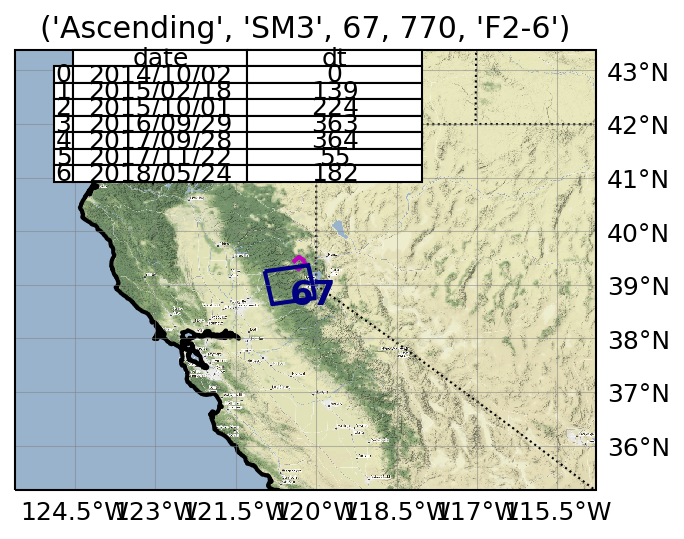

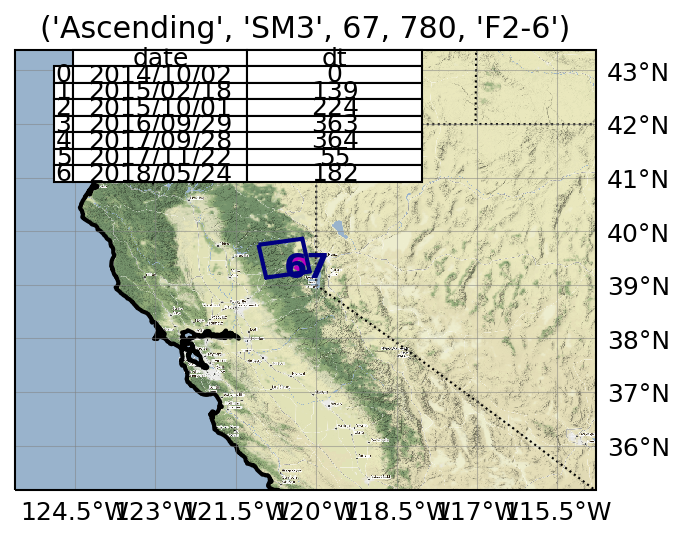

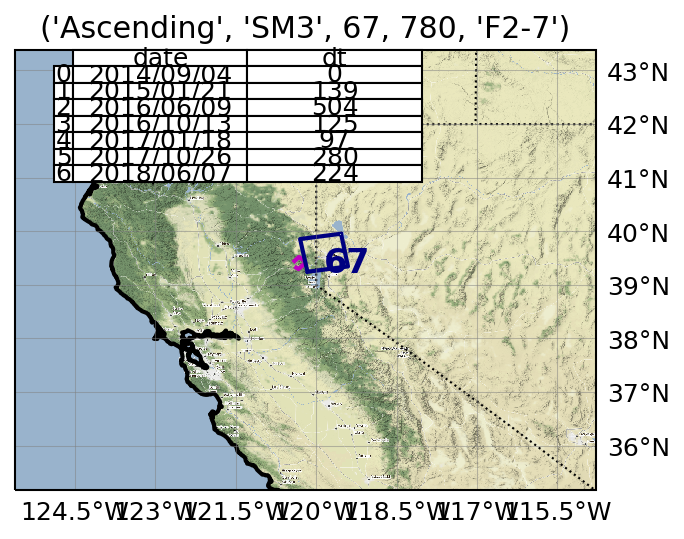

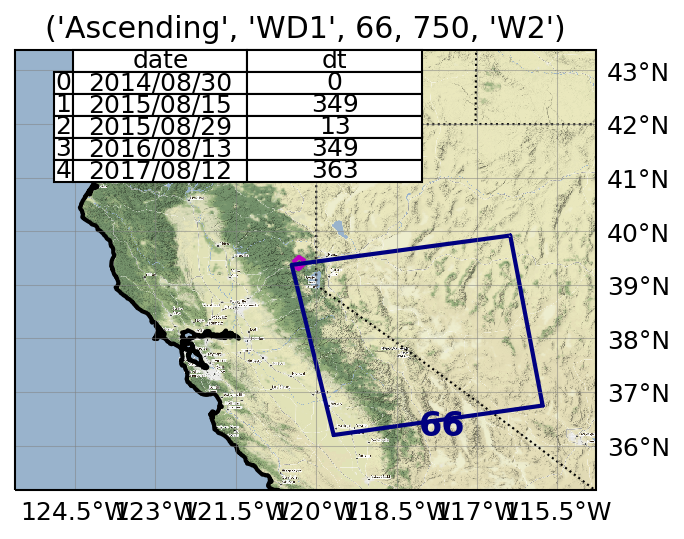

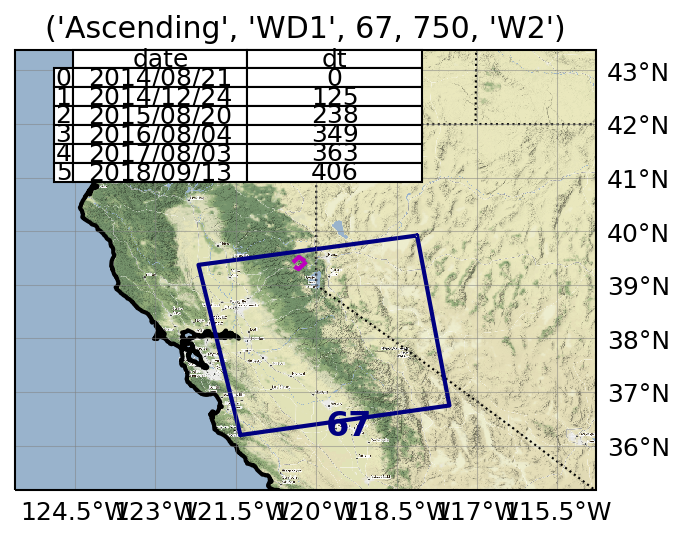

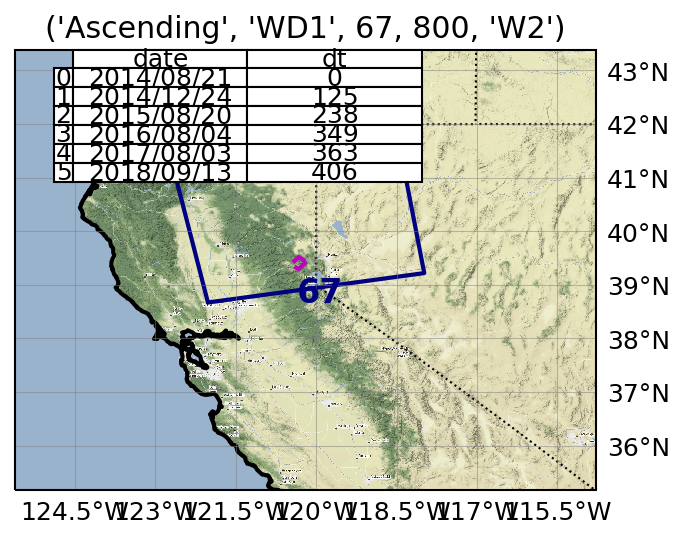

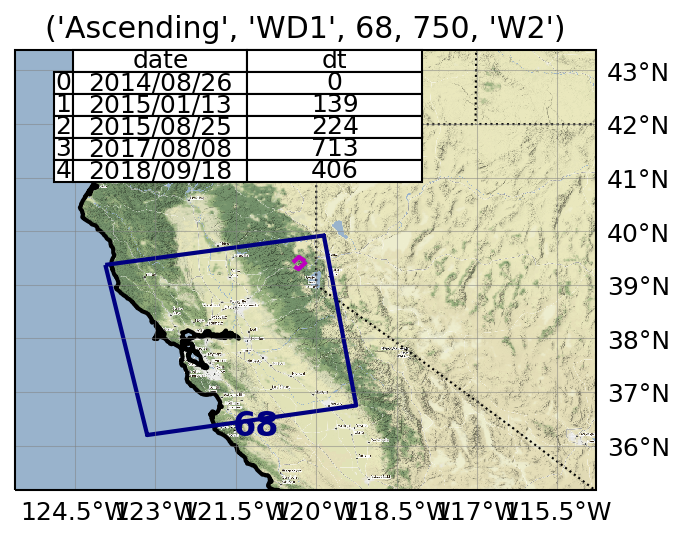

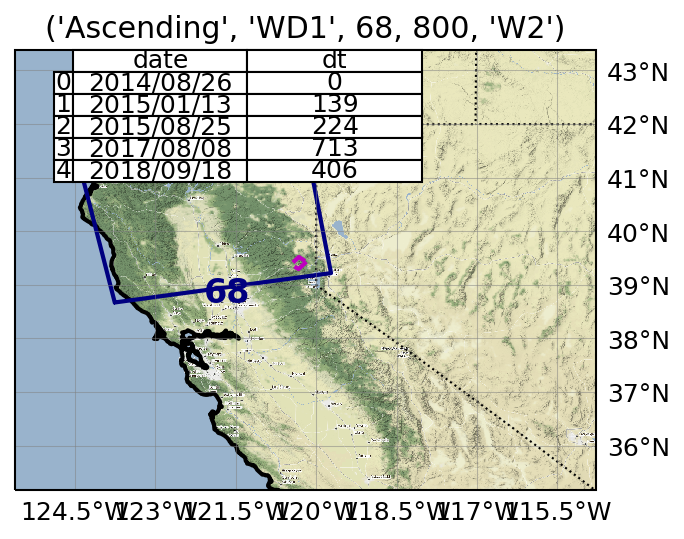

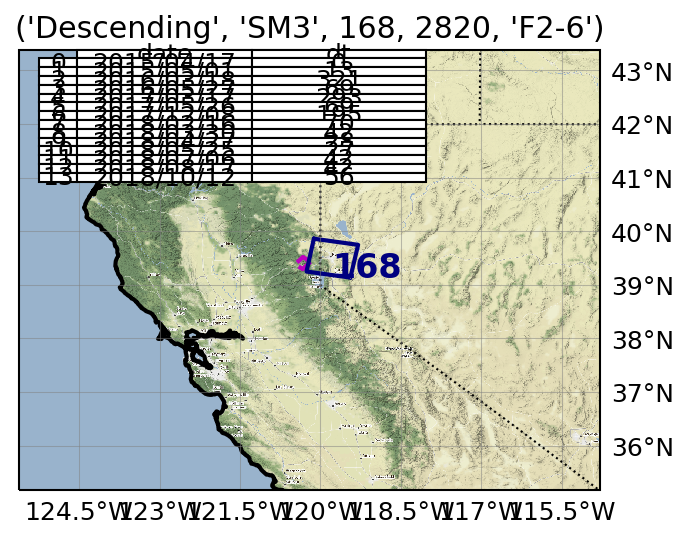

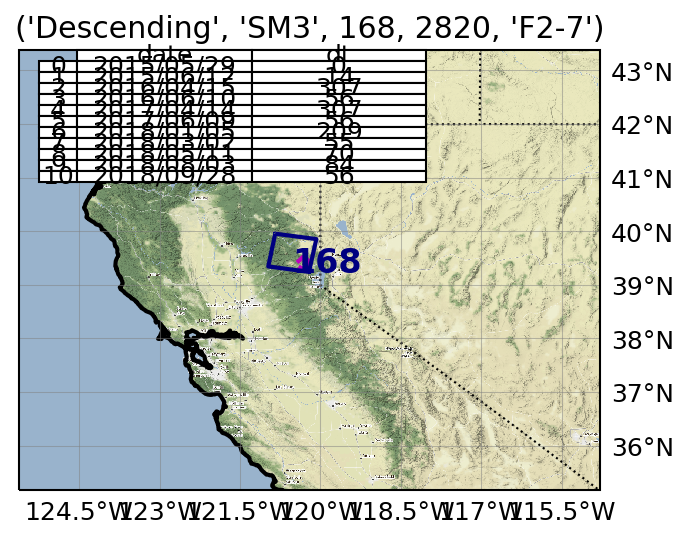

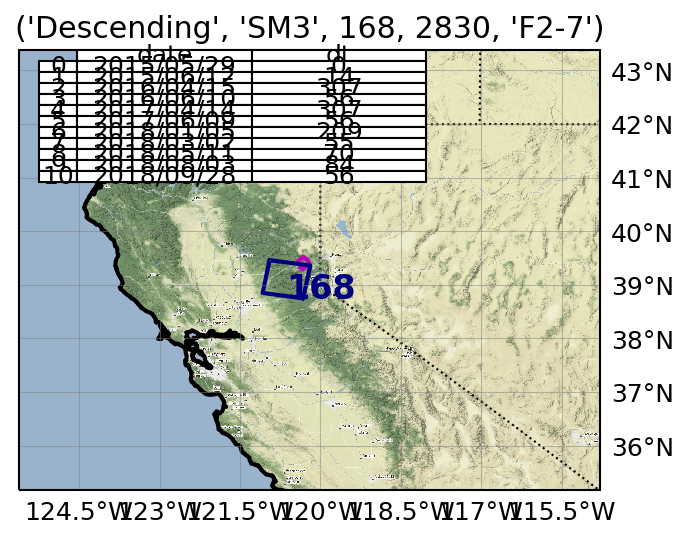

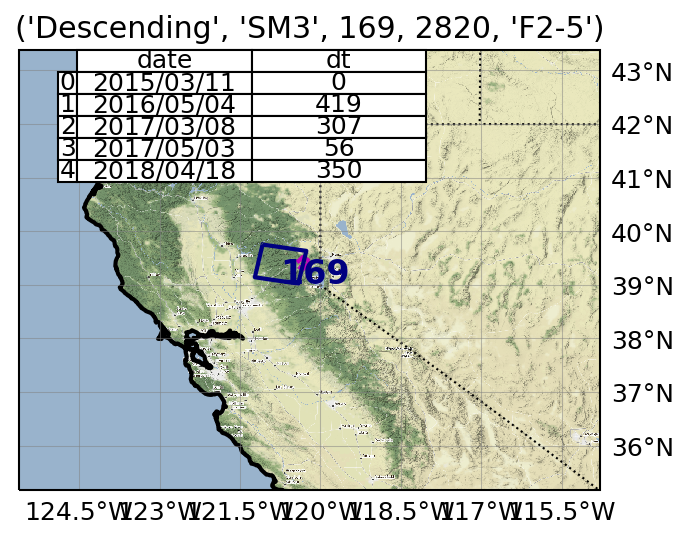

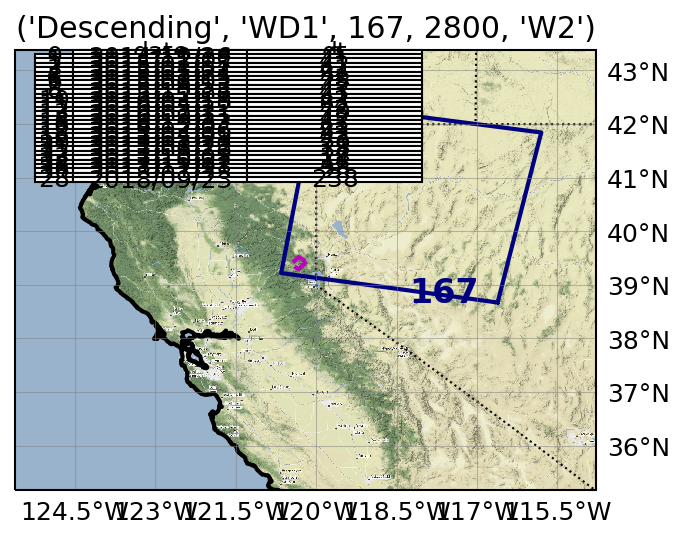

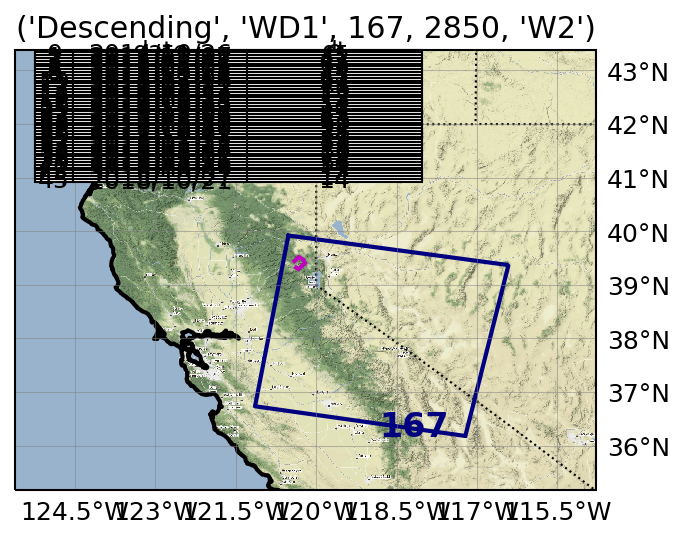

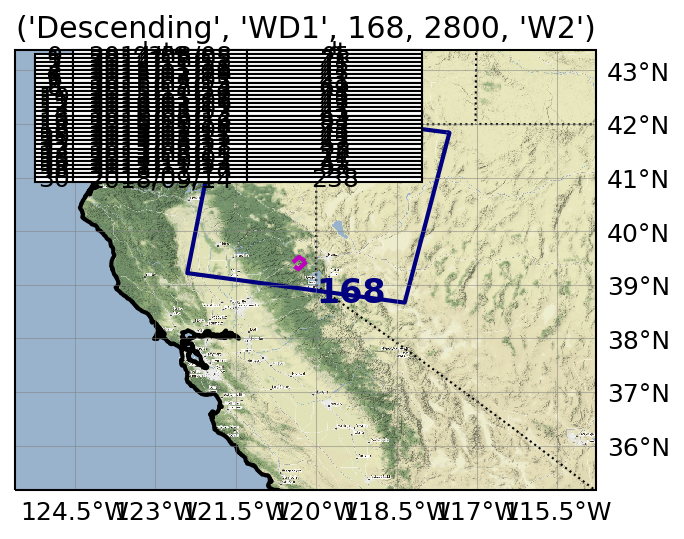

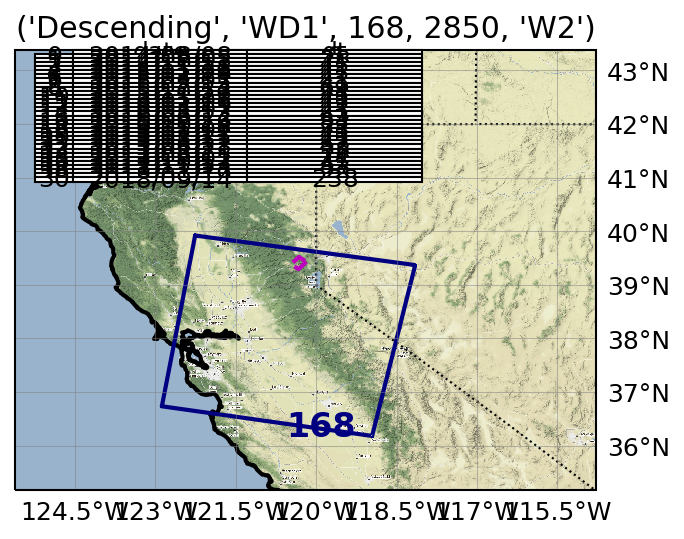

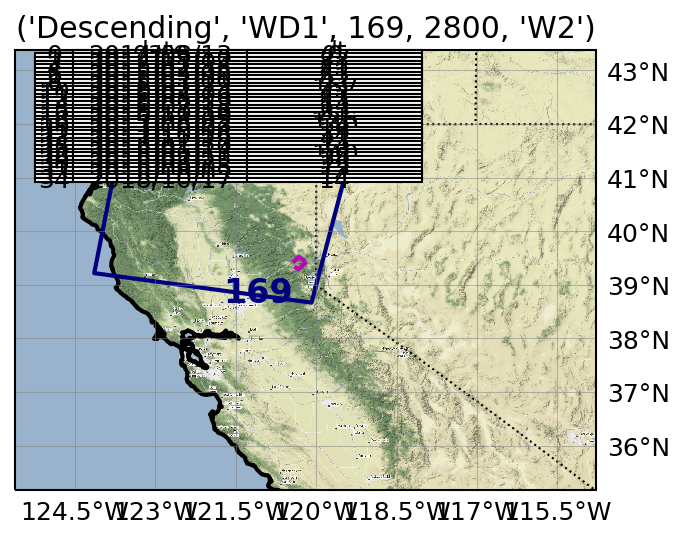

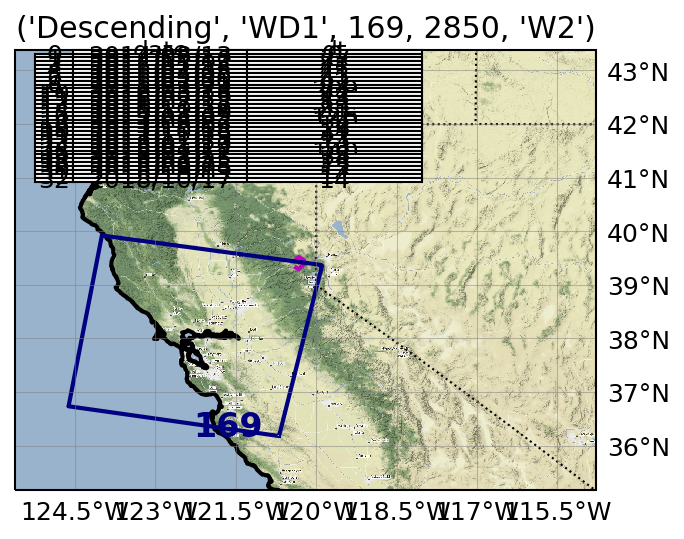

In [17]:
# Print maps for all combinations of possible interferometric pairs!
for labels, indices in GB.groups.items():
    #print(labels, indices)
    #print(labels, DF.loc[indices, "Scene ID"].tolist())
    inventory = GF.loc[indices]
    tmp = print_dates(inventory)
    plot_map(inventory, snwe, vectorFile, title=str(labels), tableFrame=tmp)